In [ ]:
# ✅ Install dependencies
%pip install tensorflow numpy mediapipe opencv-python tensorflowjs pyautogui matplotlib seaborn scikit-learn ipython

In [4]:
# ✅ Import library
import cv2
import numpy as np
import mediapipe as mp
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from IPython.display import display, HTML

In [5]:
# Inisialisasi mediapipe hands
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1)


In [6]:
# Konversi gambar ke landmark dari folder ss dan transfer_ss di dalam folder dataset
DATASET_DIR = "dataset"  # folder dengan subfolder ss dan transfer_ss
X, y = [], []

for label_folder in os.listdir(DATASET_DIR):
    folder_path = os.path.join(DATASET_DIR, label_folder)
    if not os.path.isdir(folder_path):
        continue
    for img_file in tqdm(os.listdir(folder_path)):
        img_path = os.path.join(folder_path, img_file)
        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.flip(img, 1)
        rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        result = hands.process(rgb)
        if result.multi_hand_landmarks:
            for hand_landmarks in result.multi_hand_landmarks:
                landmarks = []
                for lm in hand_landmarks.landmark:
                    landmarks.extend([lm.x, lm.y])
                if len(landmarks) == 42:
                    X.append(landmarks)
                    y.append(label_folder.lower())

X = np.array(X)
y = np.array(y)
np.save("X_from_images.npy", X)
np.save("y_from_images.npy", y)
print(f"Dataset berhasil dikonversi: {X.shape[0]} samples.")


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'dataset'

In [ ]:
# Preprocessing dan split dataset
X = np.load("X_from_images.npy")
y = np.load("y_from_images.npy")
le = LabelEncoder()
y = le.fit_transform(y)
X = X.reshape(X.shape[0], 1, X.shape[1])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [3]:
# ✅ Deteksi tangan dengan MediaPipe
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
hands = mp_hands.Hands(min_detection_confidence=0.5, min_tracking_confidence=0.5)


NameError: name 'mp' is not defined

In [9]:
# ✅ Split data + model training + validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Sequential([
    LSTM(64, return_sequences=True, activation='relu', input_shape=(1, X.shape[2])),
    LSTM(64, return_sequences=False, activation='relu'),
    Dense(64, activation='relu'),
    Dense(len(set(y)), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=30, batch_size=16, validation_data=(X_test, y_test))




Epoch 1/30


20/20 [==============================] - 2s 19ms/step - loss: 0.6933 - accuracy: 0.4469 - val_loss: 0.6935 - val_accuracy: 0.4500
Epoch 2/30
20/20 [==============================] - 0s 4ms/step - loss: 0.6914 - accuracy: 0.5125 - val_loss: 0.6912 - val_accuracy: 0.4500
Epoch 3/30
20/20 [==============================] - 0s 3ms/step - loss: 0.6876 - accuracy: 0.5125 - val_loss: 0.6850 - val_accuracy: 0.4500
Epoch 4/30
20/20 [==============================] - 0s 3ms/step - loss: 0.6714 - accuracy: 0.5406 - val_loss: 0.6571 - val_accuracy: 0.5875
Epoch 5/30
20/20 [==============================] - 0s 4ms/step - loss: 0.6320 - accuracy: 0.6438 - val_loss: 0.5938 - val_accuracy: 0.6125
Epoch 6/30
20/20 [==============================] - 0s 4ms/step - loss: 0.5488 - accuracy: 0.6875 - val_loss: 0.4757 - val_accuracy: 0.7875
Epoch 7/30
20/20 [==============================] - 0s 4ms/step - loss: 0.4794 - accuracy: 0.7531 - val_loss: 0.4422 - val_accuracy: 0.7875
Epoch 8/30
20/2

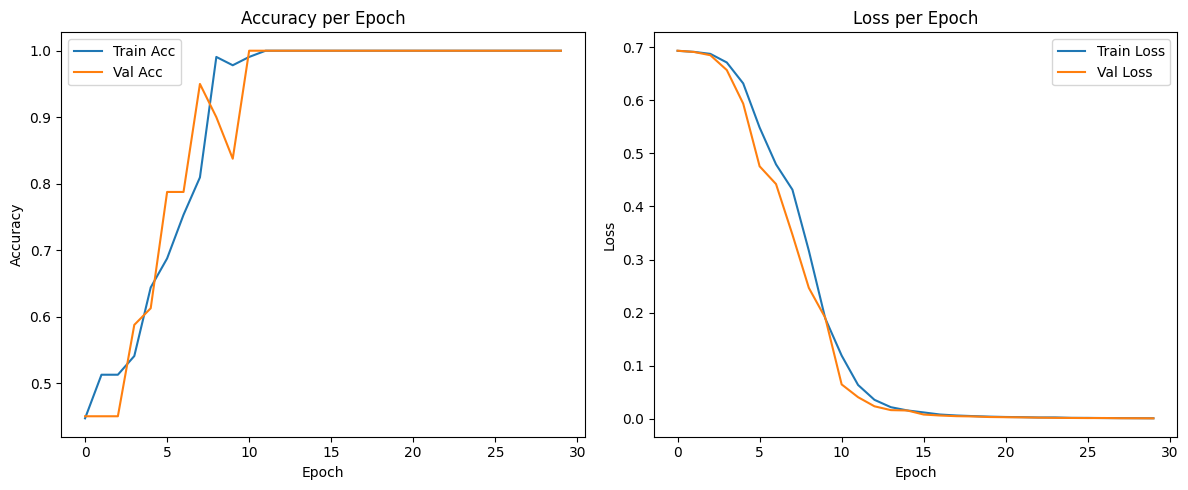

In [10]:
# ✅ Plot accuracy dan loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()


3/3 [==============================] - 0s 2ms/step


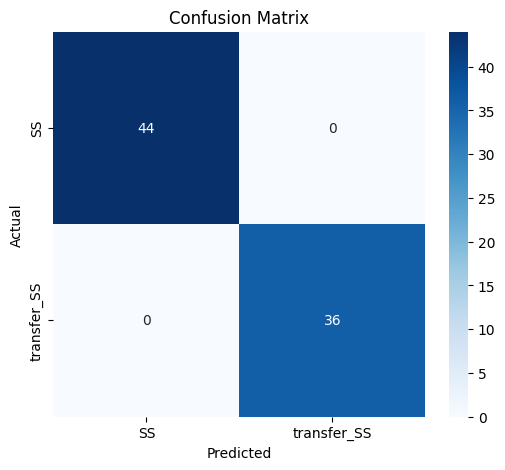

Accuracy: 100.00%
Precision: 100.00%
Recall: 100.00%
F1-score: 100.00%


In [11]:
# ✅ Confusion matrix dan evaluasi model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

report = classification_report(y_test, y_pred_classes, target_names=le.classes_, output_dict=True)
accuracy = report['accuracy'] * 100
precision = report['weighted avg']['precision'] * 100
recall = report['weighted avg']['recall'] * 100
f1 = report['weighted avg']['f1-score'] * 100

print(f"Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.2f}%")
print(f"Recall: {recall:.2f}%")
print(f"F1-score: {f1:.2f}%")


In [12]:
# ✅ (Opsional) Tampilkan metrik dalam format besar HTML
html = f"""
<h3><strong>Accuracy:</strong> {accuracy:.2f}%</h3>
<h3><strong>Precision:</strong> {precision:.2f}%</h3>
<h3><strong>Recall:</strong> {recall:.2f}%</h3>
<h3><strong>F1-score:</strong> {f1:.2f}%</h3>
"""
display(HTML(html))


In [13]:
# ✅ Simpan model
model.save("hand_gesture_model.keras")


In [ ]:
# ✅ Real-time prediksi gesture via webcam
model = tf.keras.models.load_model("hand_gesture_model.keras")
cap = cv2.VideoCapture(0)

while cap.isOpened():
    ret, frame = cap.read()
    frame = cv2.flip(frame, 1)
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    result = hands.process(rgb_frame)

    if result.multi_hand_landmarks:
        for hand_landmarks in result.multi_hand_landmarks:
            landmarks = []
            for lm in hand_landmarks.landmark:
                landmarks.append(lm.x)
                landmarks.append(lm.y)
            landmarks = np.array(landmarks).reshape(1, 1, -1)
            prediction = model.predict(landmarks)
            class_index = np.argmax(prediction)
            class_label = le.inverse_transform([class_index])[0]
            cv2.putText(frame, class_label, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
            mp_drawing.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)
    cv2.imshow("Hand Gesture Recognition", frame)
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()




1/1 [==============================] - 0s 358ms/step


NameError: name 'le' is not defined

: 